<a href="https://colab.research.google.com/github/NitzanEz/Final-Project/blob/main/ASD_MRI_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Detection and Classification of ASD through Brain MRI Images Using Deep Learning**  

## **1. Setting Up Local Storage for Dataset**

### **1.1 Connecting To git**

In [1]:
!git clone https://github.com/NitzanEz/Final-Project.git


Cloning into 'Final-Project'...
remote: Enumerating objects: 124589, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 124589 (delta 44), reused 9 (delta 9), pack-reused 124527 (from 4)
Receiving objects: 100% (124589/124589), 2.99 GiB | 17.90 MiB/s, done.
Resolving deltas: 100% (3035/3035), done.
Updating files: 100% (27607/27607), done.


## **2. Importing Required Libraries**

In [2]:
import sys
import os
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from matplotlib import rcParams
rcParams['figure.dpi'] = 300
%matplotlib inline
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score
import numpy as np
import pandas as pd
from keras.models import Sequential
from google.colab import files
import glob

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import *
from keras.models import Sequential

from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import *

print(f'Tensorflow Version: {tf.__version__}.')

Tensorflow Version: 2.17.1.


In [3]:
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.data_adapters")


## **3. Setting Up the Environment**

In [4]:

gpu_device_location = tpu_device_location = cpu_device_location = None

if 'COLAB_GPU' in os.environ and os.environ['COLAB_GPU'] == '1':
    print("Allocated GPU Runtime Details:")
    !nvidia-smi
    print()
    try:
        # Ensure pynvml is installed
        !pip install pynvml --quiet
        import pynvml
        pynvml.nvmlInit()
        handle = pynvml.nvmlDeviceGetHandleByIndex(0)
        gpu_device_name = pynvml.nvmlDeviceGetName(handle)

        if gpu_device_name not in {b'Tesla T4', b'Tesla P4', b'Tesla P100-PCIE-16GB'}:
            raise Exception(
                "Unfortunately, this instance does not have a T4, P4, or P100 GPU.\n"
                "Sometimes Colab allocates a Tesla K80 instead of a T4, P4, or P100.\n"
                "If you get Tesla K80, you can factory reset your runtime to get another GPU."
            )

        gpu_device_location = tf.test.gpu_device_name()
        print(f"{gpu_device_name.decode('utf-8')} is allocated successfully at location: {gpu_device_location}")

    except Exception as hardware_exception:
        print(f"Error: {hardware_exception}\n")
        gpu_device_location = None

elif 'COLAB_TPU_ADDR' in os.environ:
    tpu_device_location = f"grpc://{os.environ['COLAB_TPU_ADDR']}"
    print(f"TPU is allocated successfully at location: {tpu_device_location}.")
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_device_location)
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    tpu_strategy = tf.distribute.TPUStrategy()

else:
    cpu_device_location = "/cpu:0"
    print("GPUs and TPUs are not allocated successfully. Falling back to CPU.")


Allocated GPU Runtime Details:
Wed Jan 29 12:20:57 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              41W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+------------------------------------

### **3.1 Installation of `tree` Utility Using `Bash`.**  

In [5]:
%%bash
RED_COLOR='\033[0;31m'
NO_COLOR='\033[0m'
pkg_name=tree
dpkg -s $pkg_name &> /dev/null
if [ "$?" -ne "0" ]
    then
        echo "Installing tree utility..."
        apt-get autoclean
        apt-get autoremove
        apt-get install $pkg_name
        if [ "$?" -eq "0" ]
            then
                echo -e ${RED_COLOR}"tree utility installed sucessfully.\n"${NO_COLOR}
        fi
    else
        echo "tree utility is already installed."
fi
tree --version

Installing tree utility...
Reading package lists...
Building dependency tree...
Reading state information...
Reading package lists...
Building dependency tree...
Reading state information...
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 1s (53.5 kB/s)
Selecting previously unselected package tree.
(Reading database ... 124788 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...
tree utility installed sucessfully.

tree v2.0.

### **3.2 Display of File Structure**

In [6]:
!tree -d -C "gdrive/MyDrive/Deep_Learning_Course_Project"

gdrive/MyDrive/Deep_Learning_Course_Project  [error opening dir]

0 directories


### **3.3 Setting Up Paths to Root and Data Directories**

In [7]:
ROOT_DIR = r"/content/Final-Project"
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "Data")
TRAIN_DIR = os.path.join(DATA_ROOT_DIR, 'train')

# Print paths to verify them
print("ROOT_DIR exists:", os.path.isdir(ROOT_DIR))
print("DATA_ROOT_DIR exists:", os.path.isdir(DATA_ROOT_DIR))
print("TRAIN_DIR exists:", os.path.isdir(TRAIN_DIR))

# Create directories if they don't exist
if not os.path.isdir(ROOT_DIR):
    os.makedirs(ROOT_DIR)
    print(f"Created directory: {ROOT_DIR}")
if not os.path.isdir(DATA_ROOT_DIR):
    os.makedirs(DATA_ROOT_DIR)
    print(f"Created directory: {DATA_ROOT_DIR}")
if not os.path.isdir(TRAIN_DIR):
    os.makedirs(TRAIN_DIR)
    print(f"Created directory: {TRAIN_DIR}")

# Assertion to check all directories now exist
assert os.path.isdir(ROOT_DIR) and os.path.isdir(DATA_ROOT_DIR) and os.path.isdir(TRAIN_DIR), "One or more directories do not exist"

# Classes for classification
LABEL_CLASS = ['ASD', 'non-ASD']
IMAGE_DATA_PATHS = [os.path.join(TRAIN_DIR, asd_class) for asd_class in LABEL_CLASS]


ROOT_DIR exists: True
DATA_ROOT_DIR exists: True
TRAIN_DIR exists: True


## **4. Data Preprocessing and Exploratory Data Analysis**

In [8]:
data_distribution_count = pd.Series([len(os.listdir(path)) for path in IMAGE_DATA_PATHS if os.path.exists(path) and os.path.isdir(path)],
                                    index = LABEL_CLASS)
data_distribution_count

,0
ASD,12676
non-ASD,12264


### **4.1 Data Distribution Visualization**

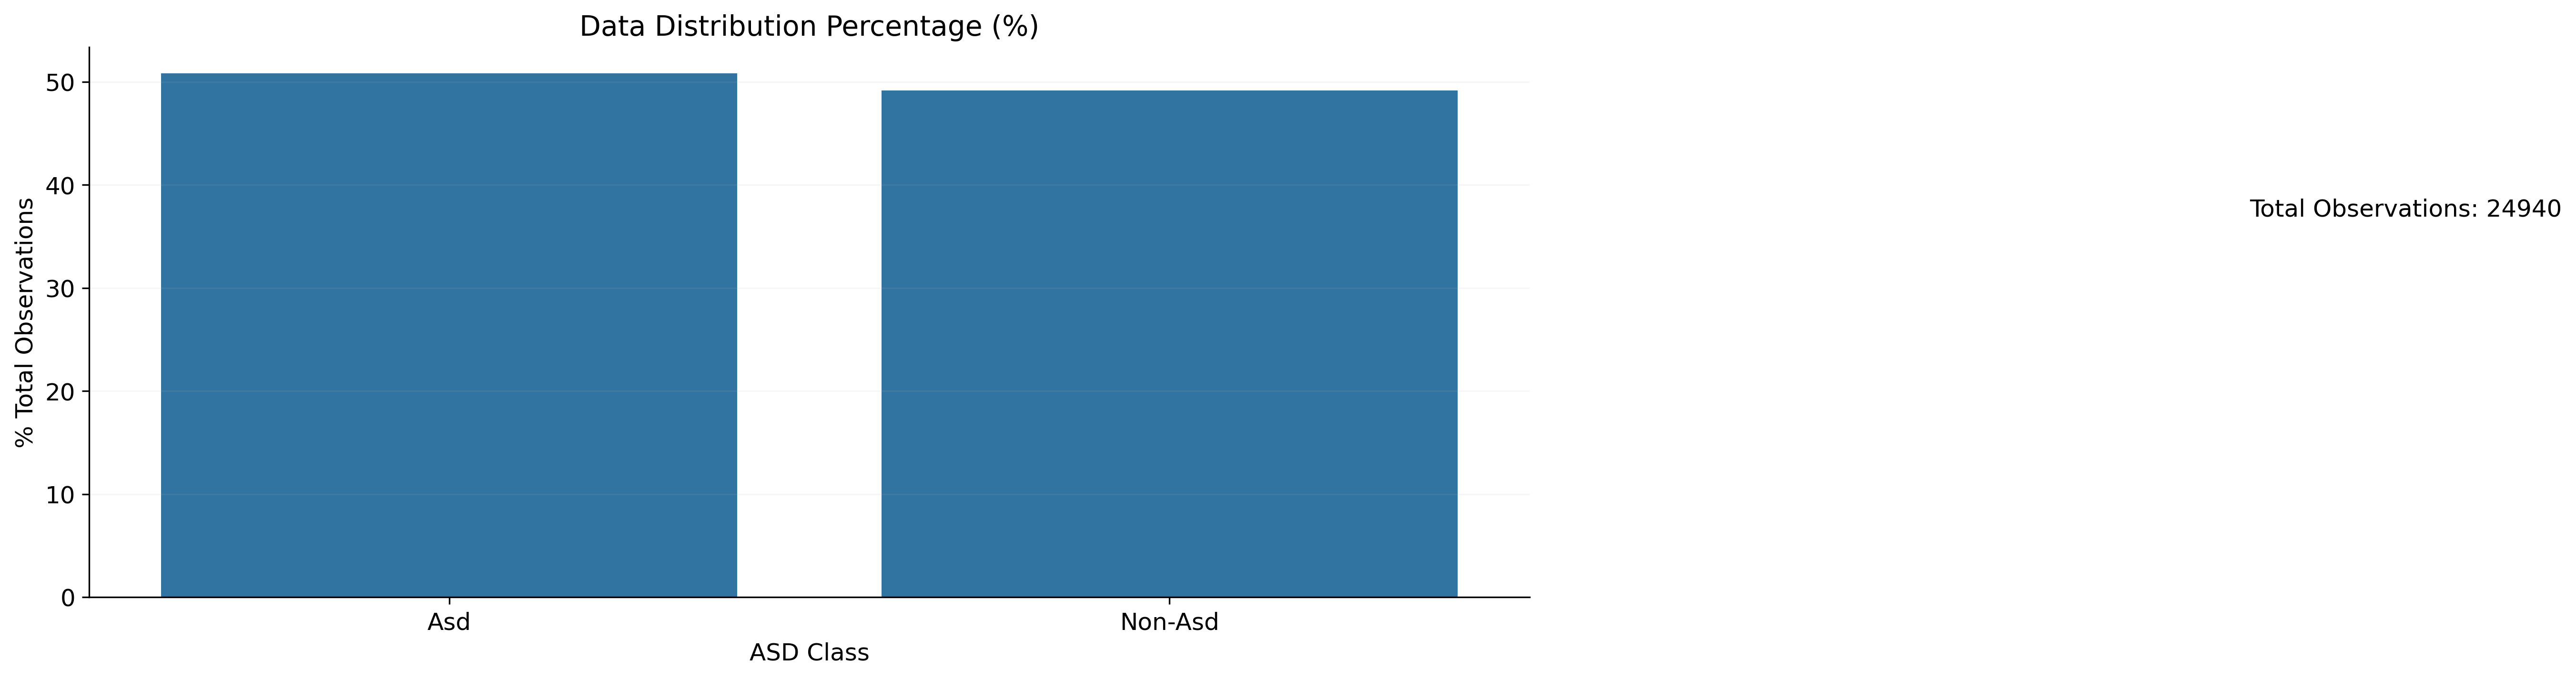

In [9]:
fig, axis = plt.subplots(figsize = (13, 5))
axis.grid(True, alpha = 0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize = 14)
sns.barplot(x = ['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index],
            y = 100 * (data_distribution_count / data_distribution_count.sum()), ax = axis)
axis.set_xlabel("ASD Class", fontsize = 12)
axis.set_ylabel("% Total Observations", fontsize = 12)
axis.tick_params(which = 'major', labelsize = 12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict = dict(size = 12))
sns.despine()

## **5. Development of Training, Validation & Testing Dataset**

In [10]:
image_data_paths = []
for curr_path, asd_name in zip(IMAGE_DATA_PATHS, LABEL_CLASS):
    if os.path.exists(curr_path) and os.path.isdir(curr_path):
        image_data_paths.extend(map(lambda filename: (os.path.join(curr_path, filename), asd_name), os.listdir(curr_path)))

In [11]:
image_data_paths_df = pd.DataFrame(image_data_paths, columns = ['image_filepaths', 'asd_class']).sample(frac = 1, random_state = 42).reset_index(drop = True)
image_data_paths_df.head()

,image_filepaths,asd_class
0,/content/Final-Project/Data/train/ASD/slice_12...,ASD
1,/content/Final-Project/Data/train/non-ASD/slic...,non-ASD
2,/content/Final-Project/Data/train/non-ASD/slic...,non-ASD
3,/content/Final-Project/Data/train/non-ASD/ABID...,non-ASD
4,/content/Final-Project/Data/train/non-ASD/slic...,non-ASD


In [12]:
image_data_paths_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24940 entries, 0 to 24939
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   image_filepaths  24940 non-null  object
 1   asd_class        24940 non-null  object
dtypes: object(2)
memory usage: 389.8+ KB


In [13]:
intermediate_train_data, test_data = train_test_split(image_data_paths_df,
                                                      train_size = 0.70,
                                                      random_state = 42,
                                                      stratify = image_data_paths_df.asd_class)

train_data, validation_data = train_test_split(intermediate_train_data,
                                               train_size = 0.80,
                                               random_state = 42,
                                               stratify = intermediate_train_data.asd_class)

## **6. Training, Validation and Testing Dataset Data Distribution Visualization**

<ipython-input-14-7b5d448ca8de>:10: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  curr_axis.grid(False, alpha=0.1)
<ipython-input-14-7b5d448ca8de>:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  curr_axis.set_xticklabels(["\n".join(xtick.split("_")).title() for xtick in LABEL_CLASS])
<ipython-input-14-7b5d448ca8de>:10: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  curr_axis.grid(False, alpha=0.1)
<ipython-input-14-7b5d448ca8de>:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  curr_axis.set_xticklabels(["\n".join(xtick.split("_")).title() for xtick in LABEL_CLASS])
<ipython-input-14-7b5d448ca8de>:10: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid 

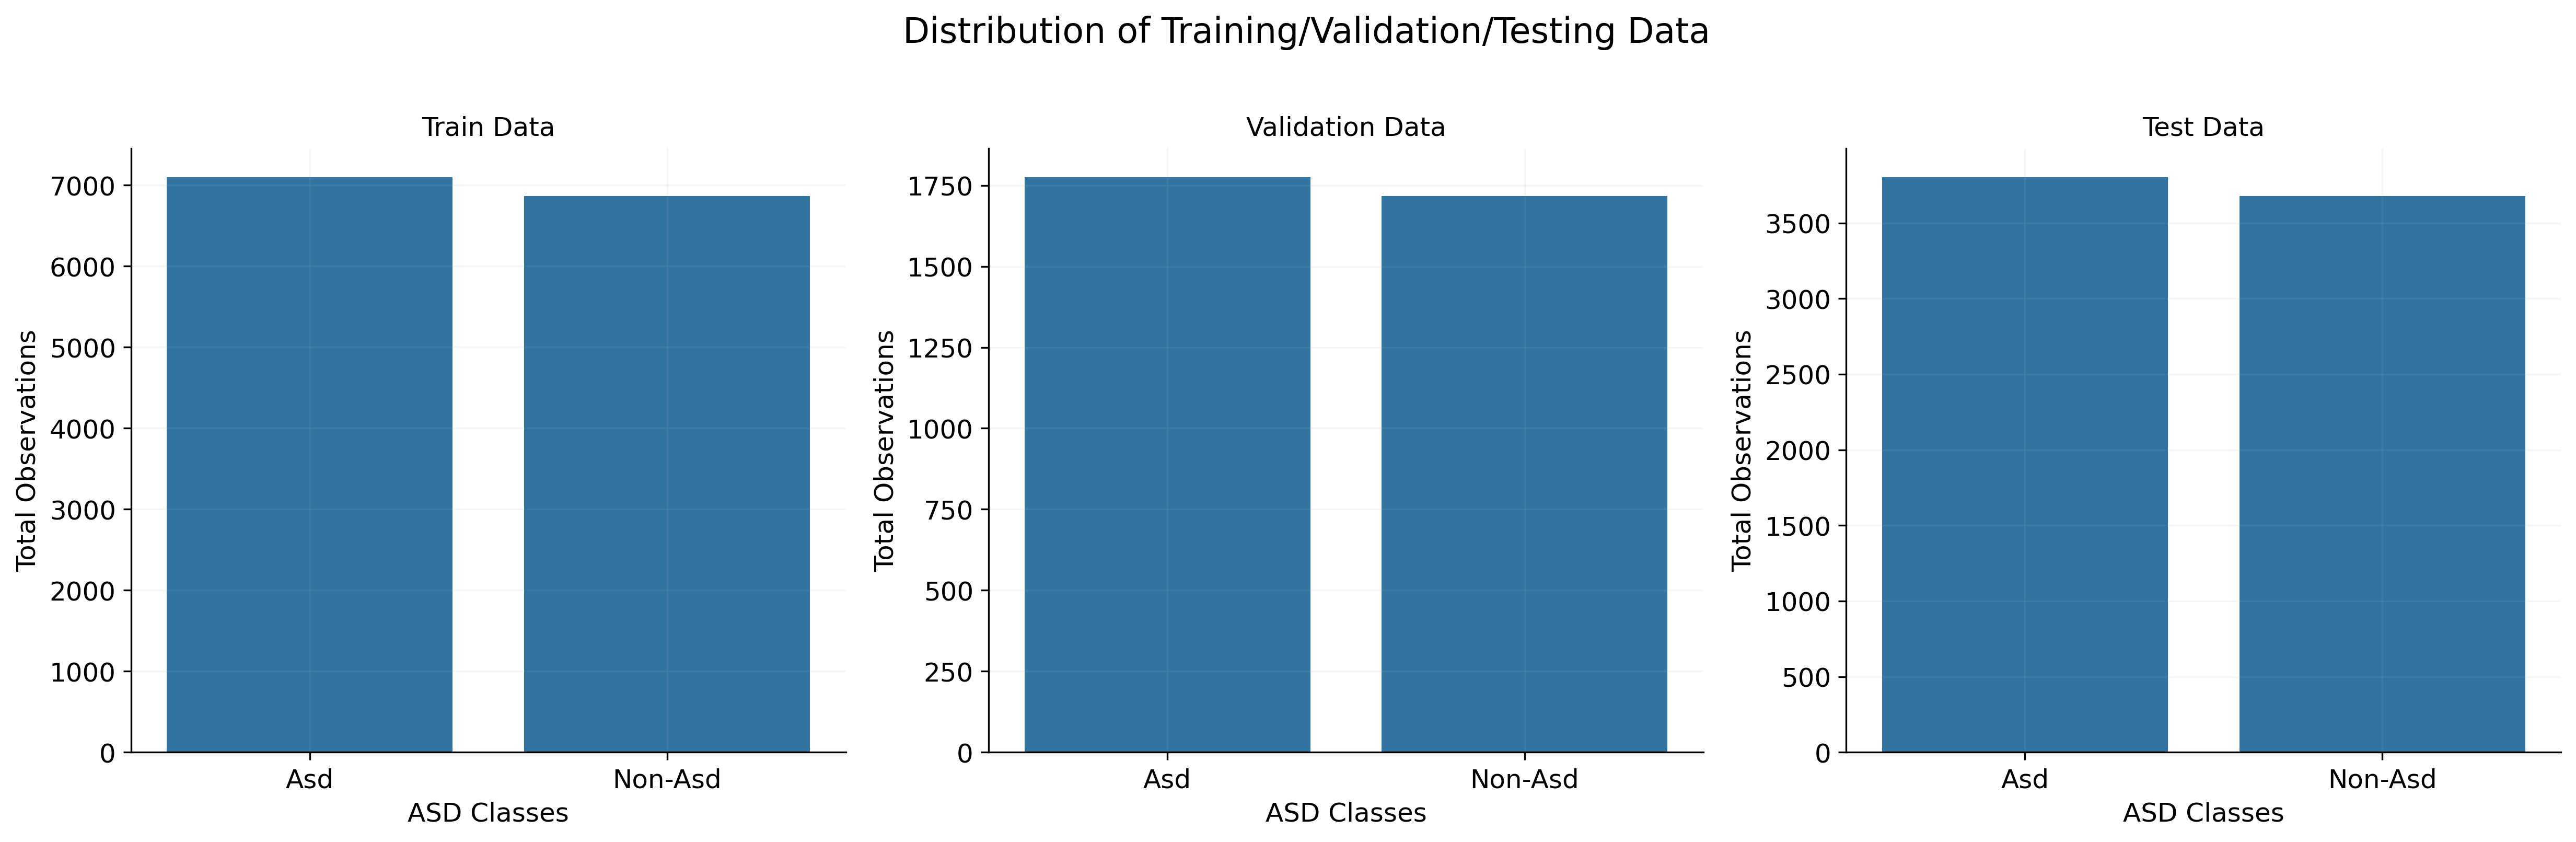

In [14]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 5))
fig.suptitle("Distribution of Training/Validation/Testing Data", fontsize=16, fontdict=dict(fontweight='bold'), y=1.05)

# Make sure train_data, validation_data, and test_data are defined and have the attribute 'label_class'
sns.countplot(x=train_data.asd_class, order=LABEL_CLASS, ax=axes[0])
sns.countplot(x=validation_data.asd_class, order=LABEL_CLASS, ax=axes[1])
sns.countplot(x=test_data.asd_class, order=LABEL_CLASS, ax=axes[2])

for curr_axis, curr_title in zip(axes, ['Train Data', 'Validation Data', 'Test Data']):
    curr_axis.grid(False, alpha=0.1)
    curr_axis.set_title(curr_title, fontsize=12)
    curr_axis.set_xlabel("ASD Classes", fontsize=12)
    curr_axis.set_ylabel("Total Observations", fontsize=12)
    curr_axis.tick_params(which='major', labelsize=12)
    curr_axis.set_xticklabels(["\n".join(xtick.split("_")).title() for xtick in LABEL_CLASS])

sns.despine()
plt.show()  # To ensure the plot is displayed, especially outside of interactive environments like Jupyter Notebooks


## **7. Data/Image Augmentation**
* Image augmentation is usually used to increase the image dataset and also to make the network more robust against translation invariance. Image augmentation is defined as creating duplicates of the original image datasets by flipping, rotating, zooming, and adjusting brightness.

* We will use data/image augmentation using `ImageDataGenerator` class to train the model on different types of combinations formed by rotation, flipping, changing the brightness etc of an image so as to increase our model accuracy.

In [15]:
custom_lr = 0.0001
image_size = 128
batch_size = 32
dropout = 0.3

In [16]:

image_datagen_kwargs = dict(rescale = 1 / 255,
                            rotation_range = 15,
                            width_shift_range = 0.1,
                            zoom_range = 0.01,
                            shear_range = 0.01,
                            brightness_range = [0.3, 1.5],
                            horizontal_flip = True,
                            vertical_flip = True)

In [17]:
train_image_datagen = ImageDataGenerator(**image_datagen_kwargs)
validation_image_datagen = ImageDataGenerator(**image_datagen_kwargs)
test_image_datagen = ImageDataGenerator(**image_datagen_kwargs)

In [18]:
train_dataset = train_image_datagen.flow_from_dataframe(train_data,
                                                        x_col = 'image_filepaths',
                                                        y_col = 'asd_class',
                                                        seed = 42,
                                                        batch_size = batch_size,
                                                        target_size = (image_size, image_size),
                                                        color_mode = 'rgb')
validation_dataset = validation_image_datagen.flow_from_dataframe(validation_data,
                                                                  x_col = 'image_filepaths',
                                                                  y_col = 'asd_class',
                                                                  seed = 42,
                                                                  batch_size = batch_size,
                                                                  target_size = (image_size, image_size),
                                                                  color_mode = 'rgb')
test_dataset = test_image_datagen.flow_from_dataframe(test_data,
                                                      x_col = 'image_filepaths',
                                                      y_col = 'asd_class',
                                                      seed = 42,
                                                      batch_size = batch_size,
                                                      target_size = (image_size, image_size),
                                                      color_mode = 'rgb')

Found 13966 validated image filenames belonging to 2 classes.
Found 3492 validated image filenames belonging to 2 classes.
Found 7482 validated image filenames belonging to 2 classes.


In [19]:
print("Information about Training Dataset:")
print(train_dataset.class_indices)
print(train_dataset.image_shape, end = '\n\n')

print("Information about Validation Dataset:")
print(validation_dataset.class_indices)
print(validation_dataset.image_shape, end = '\n\n')

print("Information about Testing Dataset:")
print(test_dataset.class_indices)
print(test_dataset.image_shape)

Information about Training Dataset:
{'ASD': 0, 'non-ASD': 1}
(128, 128, 3)

Information about Validation Dataset:
{'ASD': 0, 'non-ASD': 1}
(128, 128, 3)

Information about Testing Dataset:
{'ASD': 0, 'non-ASD': 1}
(128, 128, 3)


### **7.1 Training Data Images Glimpse**

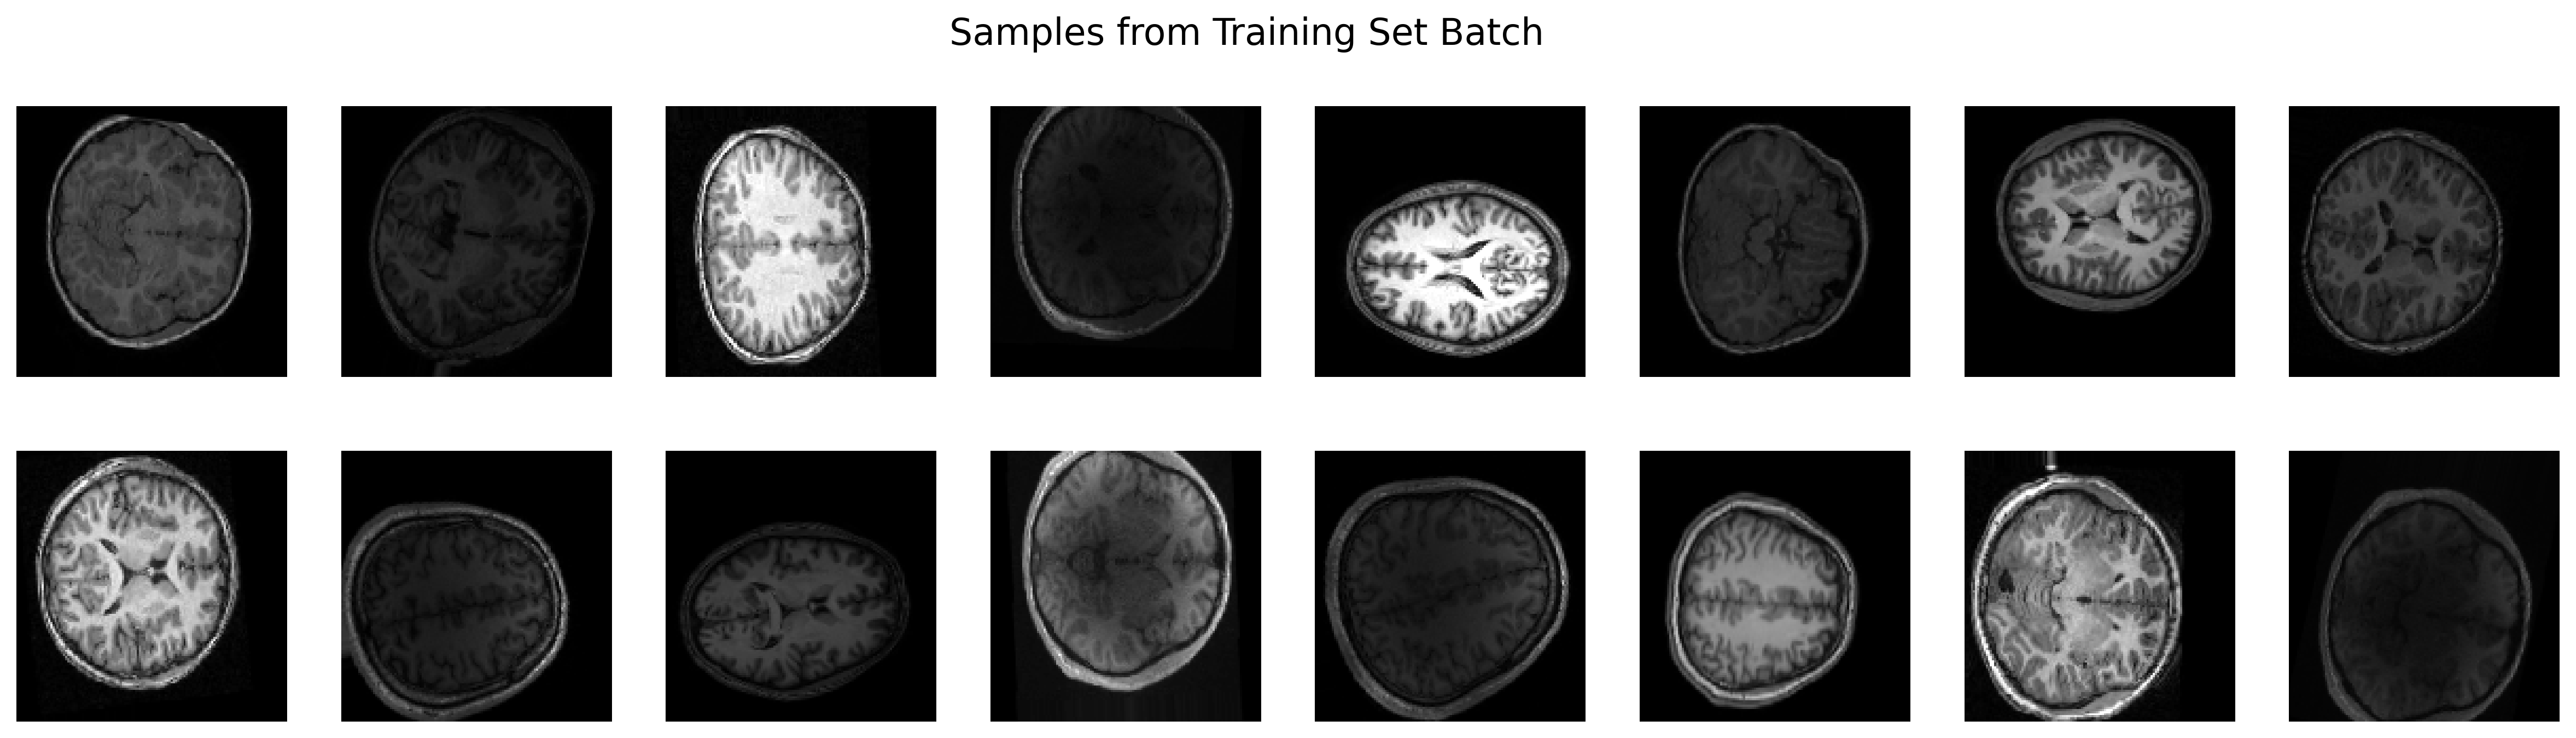

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(20, 5))
fig.suptitle("Samples from Training Set Batch", fontsize=16, fontdict=dict(fontweight='bold'))

# Assuming train_dataset is defined and has the correct structure
for curr_axis, curr_image in zip(axes.flatten(), train_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap='gray')
    curr_axis.axis('off')  # Use 'off' instead of False to turn off axis

plt.show()  # Display the plot, particularly outside interactive environments


### **7.2 Validation Data Images Glimpse**

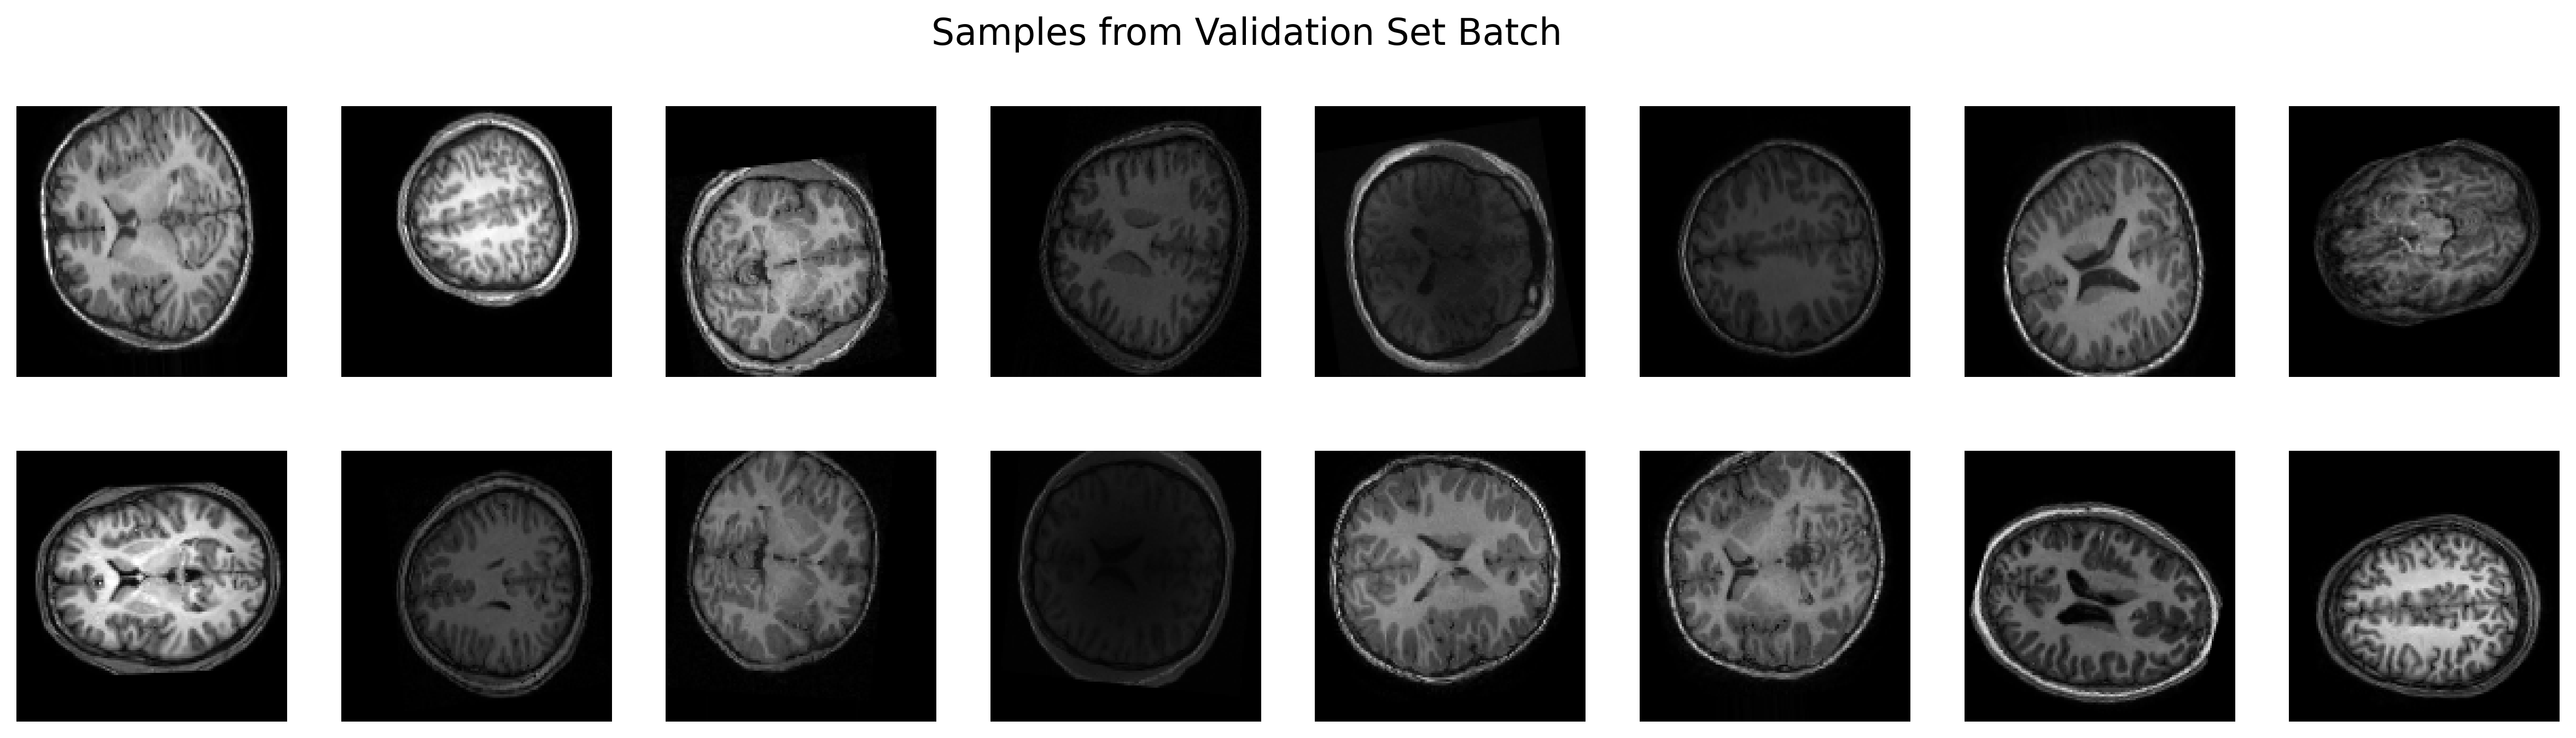

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(20, 5))
fig.suptitle("Samples from Validation Set Batch", fontsize=16, fontdict=dict(fontweight='bold'))

# Assuming validation_dataset is defined and has the correct structure
for curr_axis, curr_image in zip(axes.flatten(), validation_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap='gray')
    curr_axis.axis('off')  # Use 'off' instead of False for turning off axis labels and ticks

plt.show()  # Display the plot, especially if running in a script or non-interactive environment


### **7.3 Testing Data Images Glimpse**

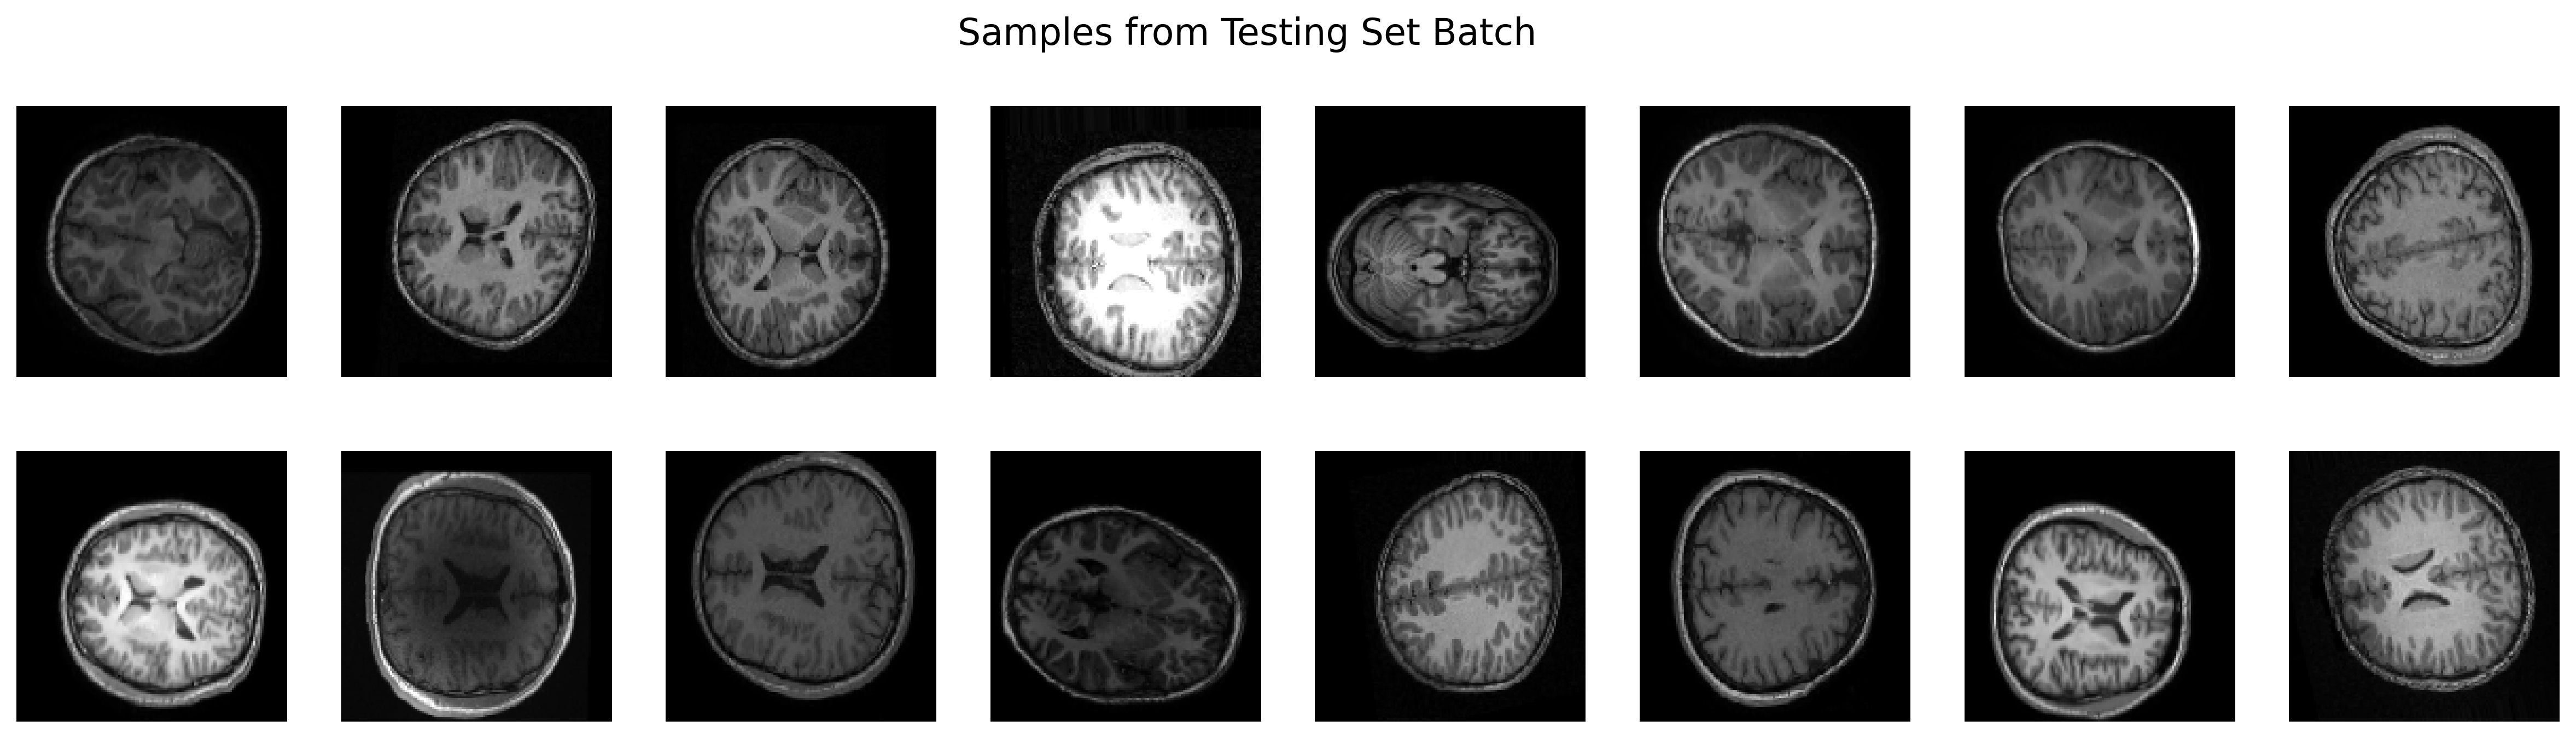

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(20, 5))
fig.suptitle("Samples from Testing Set Batch", fontsize=16, fontdict=dict(fontweight='bold'))

# Assuming test_dataset is defined and has the correct structure
for curr_axis, curr_image in zip(axes.flatten(), test_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap='gray')
    curr_axis.axis('off')  # Use 'off' to turn off the axis labels and ticks

plt.show()  # Display the plot, especially useful in scripts or non-interactive environments


## **8. Model Development**

In [23]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 10)

In [24]:
ROOT_DIR = "/content/Final-Project/Data"  # Update this to your actual root directory path
ROOT_CHECKPOINT_DIR_PATH = "/content/Final-Project/Model-Checkpoints/"
INCEPTIONV3_CHECKPOINT_DIR_PATH = os.path.join(ROOT_CHECKPOINT_DIR_PATH, "InceptionV3")

# Create the directories if they don't exist
for path in [ROOT_CHECKPOINT_DIR_PATH, INCEPTIONV3_CHECKPOINT_DIR_PATH]:
    if not os.path.isdir(path):
        os.makedirs(path)
        print(f"Created directory: {path}")

# Assert to check all directories now exist
assert os.path.isdir(ROOT_CHECKPOINT_DIR_PATH)  and os.path.isdir(INCEPTIONV3_CHECKPOINT_DIR_PATH), "One or more directories do not exist"


Created directory: /content/Final-Project/Model-Checkpoints/InceptionV3


In [25]:
# Define the checkpoint directory
INCEPTIONV3_CHECKPOINT_DIR_PATH = 'ROOT_DIR'
os.makedirs(INCEPTIONV3_CHECKPOINT_DIR_PATH, exist_ok=True)  # Create the directory if it does not exist

inceptionv3_cp_callback = ModelCheckpoint(
    filepath=os.path.join(
        INCEPTIONV3_CHECKPOINT_DIR_PATH,
        "best_inceptionv3_weights-val_accuracy{val_accuracy:.2f}.weights.h5"  # Corrected file extension
    ),
    monitor='val_accuracy',        # Monitor validation accuracy
    verbose=1,                     # Print messages when saving
    save_weights_only=True,        # Save only the model weights
    save_best_only=True,           # Save only the best model based on validation accuracy
    mode='max'                     # Save when `val_accuracy` is maximized
)


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def training_process_viz(training_stats: pd.DataFrame, **plot_kwargs) -> None:
    fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
    fig.suptitle(plot_kwargs['plot_title'], fontsize=16, fontweight='bold', y=1.08)
    for curr_axis, col_name in zip(axes, ['accuracy', 'loss']):
        curr_axis.grid(True, alpha=0.3)
        curr_axis.set_title(f"Model {col_name}".title(), fontsize=14)
        sns.lineplot(x=range(1, 1 + training_stats.shape[0]),
                     y=training_stats[col_name],
                     color='blue',
                     linewidth=2,
                     label=col_name.title(),
                     ax=curr_axis)
        sns.lineplot(x=range(1, 1 + training_stats.shape[0]),
                     y=training_stats[f"val_{col_name}"],
                     color='red',
                     linewidth=2,
                     label=f"Validation {col_name}".title(),
                     ax=curr_axis)
        curr_axis.set_xlabel("Epochs", fontsize=12)
        curr_axis.set_ylabel(col_name.title(), fontsize=12)
        curr_axis.tick_params(which='major', labelsize=12)
        curr_axis.legend(title=col_name.title())
    fig.tight_layout()
    sns.despine()

In [27]:
def confusion_matrix_viz(model, test_dataset, **plot_kwargs) -> None:
    assert isinstance(model, Sequential)
    model_preds = [np.argmax(curr_row) for curr_row in model.predict(test_dataset)]
    fig, axis = plt.subplots(figsize = (8, 6))
    class_names = ['ASD', 'NON ASD']
    sns.heatmap(confusion_matrix(test_dataset.classes, model_preds), annot = True, cmap = plt.cm.Reds, ax = axis)
    axis.set_title(plot_kwargs['plot_title'], fontsize = 14)
    axis.tick_params(which = 'major', labelsize = 12)
    axis.set_xlabel("Pedicted Class", fontsize = 12)
    axis.set_ylabel("Actual Class", fontsize = 12)
    axis.set_xticklabels(class_names, fontdict = dict(fontsize = 12))
    axis.set_yticklabels(class_names, fontdict = dict(fontsize = 12))
    fig.tight_layout()
    sns.despine()

In [28]:
def generate_report(*models, test_dataset, row_indexes) -> pd.DataFrame:
    assert len(models)
    report_df = pd.DataFrame(columns=['MAE', 'MSE', 'RMSE', 'Loss', 'Accuracy', 'F1-Score'])
    y_hat = test_dataset.classes
    for curr_index, curr_model in enumerate(models):
        assert isinstance(curr_model, Sequential)
        curr_model_loss, curr_model_accuracy = curr_model.evaluate(test_dataset)
        y_preds = np.argmax(curr_model.predict(test_dataset), axis=1)
        mae = mean_absolute_error(y_hat, y_preds)
        mse = mean_squared_error(y_hat, y_preds)
        rmse = mse ** 0.5  # √MSE instead of `squared=False`
        f1 = f1_score(y_hat, y_preds, average="micro")
        report_df.loc[curr_index] = [mae, mse, rmse, curr_model_loss, curr_model_accuracy, f1]
    report_df.index = row_indexes
    return report_df


### **8.3 Inception V3**

#### **8.3.1 Developement of InceptionV3**

In [29]:
inception_v3_model = InceptionV3(weights='imagenet',
                                 include_top = False,
                                 input_shape = (image_size, image_size, 3),
                                 pooling = 'avg')
inception_v3_model.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [30]:
# Freeze all layers in the base model
for layer in inception_v3_model.layers:
    layer.trainable = False

In [31]:
# Unfreeze some layers in the base model
for layer in inception_v3_model.layers[-50:]:  # Unfreeze the last 50 layers
    layer.trainable = True

In [32]:
inception_cnn_model = Sequential()
inception_cnn_model.add(inception_v3_model)
inception_cnn_model.add(Flatten())
inception_cnn_model.add(Dense(1024, activation = 'relu', name = 'Hidden-Layer-1'))
inception_cnn_model.add(Dense(4, activation = 'softmax', name = 'Output-Layer'))
inception_cnn_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
inception_cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 2048)                │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-Layer-1 (Dense)               │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output-Layer (Dense)                 │ (None, 4)                   │           4,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,905,060 (91.19 MB)

 Trainable params: 8,833,220 (33.70 MB)

 Non-trainable params: 15,071,840 (57.49 MB)

#### **8.3.2 Training and Validation of InceptionV3 Model**

In [33]:
custom_lr = 0.0001
inception_cnn_model = Sequential()
inception_cnn_model.add(inception_v3_model)
inception_cnn_model.add(Flatten())
inception_cnn_model.add(Dropout(0.5))  # Dropout with 50% probability
inception_cnn_model.add(Dense(1024, activation='relu', name='Hidden-Layer-1'))
inception_cnn_model.add(Dropout(0.3))  # Dropout with 30% probability
inception_cnn_model.add(Dense(2, activation='softmax', name='Output-Layer'))
optimizer = Adam(learning_rate=custom_lr)
inception_cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
inception_cnn_model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 2048)                │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden-Layer-1 (Dense)               │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output-Layer (Dense)                 │ (None, 2)                   │           2,050 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,903,010 (91.18 MB)

 Trainable params: 8,831,170 (33.69 MB)

 Non-trainable params: 15,071,840 (57.49 MB)

In [34]:
print(train_data['asd_class'].unique())


['non-ASD' 'ASD']


In [35]:
with tf.device(gpu_device_location) if gpu_device_location else tpu_strategy.scope() if tpu_device_location else tf.device(cpu_device_location):
    inception_model_train_history = inception_cnn_model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=70,
        callbacks=[early_stopping, inceptionv3_cp_callback]
    )


Epoch 1/70
435/437 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.5700 - loss: 0.7582
Epoch 1: val_accuracy improved from -inf to 0.59966, saving model to ROOT_DIR/best_inceptionv3_weights-val_accuracy0.60.weights.h5
437/437 ━━━━━━━━━━━━━━━━━━━━ 146s 274ms/step - accuracy: 0.5701 - loss: 0.7579 - val_accuracy: 0.5997 - val_loss: 0.6497
Epoch 2/70
435/437 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.6336 - loss: 0.6414
Epoch 2: val_accuracy improved from 0.59966 to 0.67268, saving model to ROOT_DIR/best_inceptionv3_weights-val_accuracy0.67.weights.h5
437/437 ━━━━━━━━━━━━━━━━━━━━ 93s 210ms/step - accuracy: 0.6337 - loss: 0.6414 - val_accuracy: 0.6727 - val_loss: 0.5772
Epoch 3/70
434/437 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.6631 - loss: 0.6016
Epoch 3: val_accuracy improved from 0.67268 to 0.69845, saving model to ROOT_DIR/best_inceptionv3_weights-val_accuracy0.70.weights.h5
437/437 ━━━━━━━━━━━━━━━━━━━━ 92s 209ms/step - accuracy: 0.6631 - loss: 0.6016 - val_accuracy: 0.

#### **8.3.3 InceptionV3 Model Training Process Statistics**

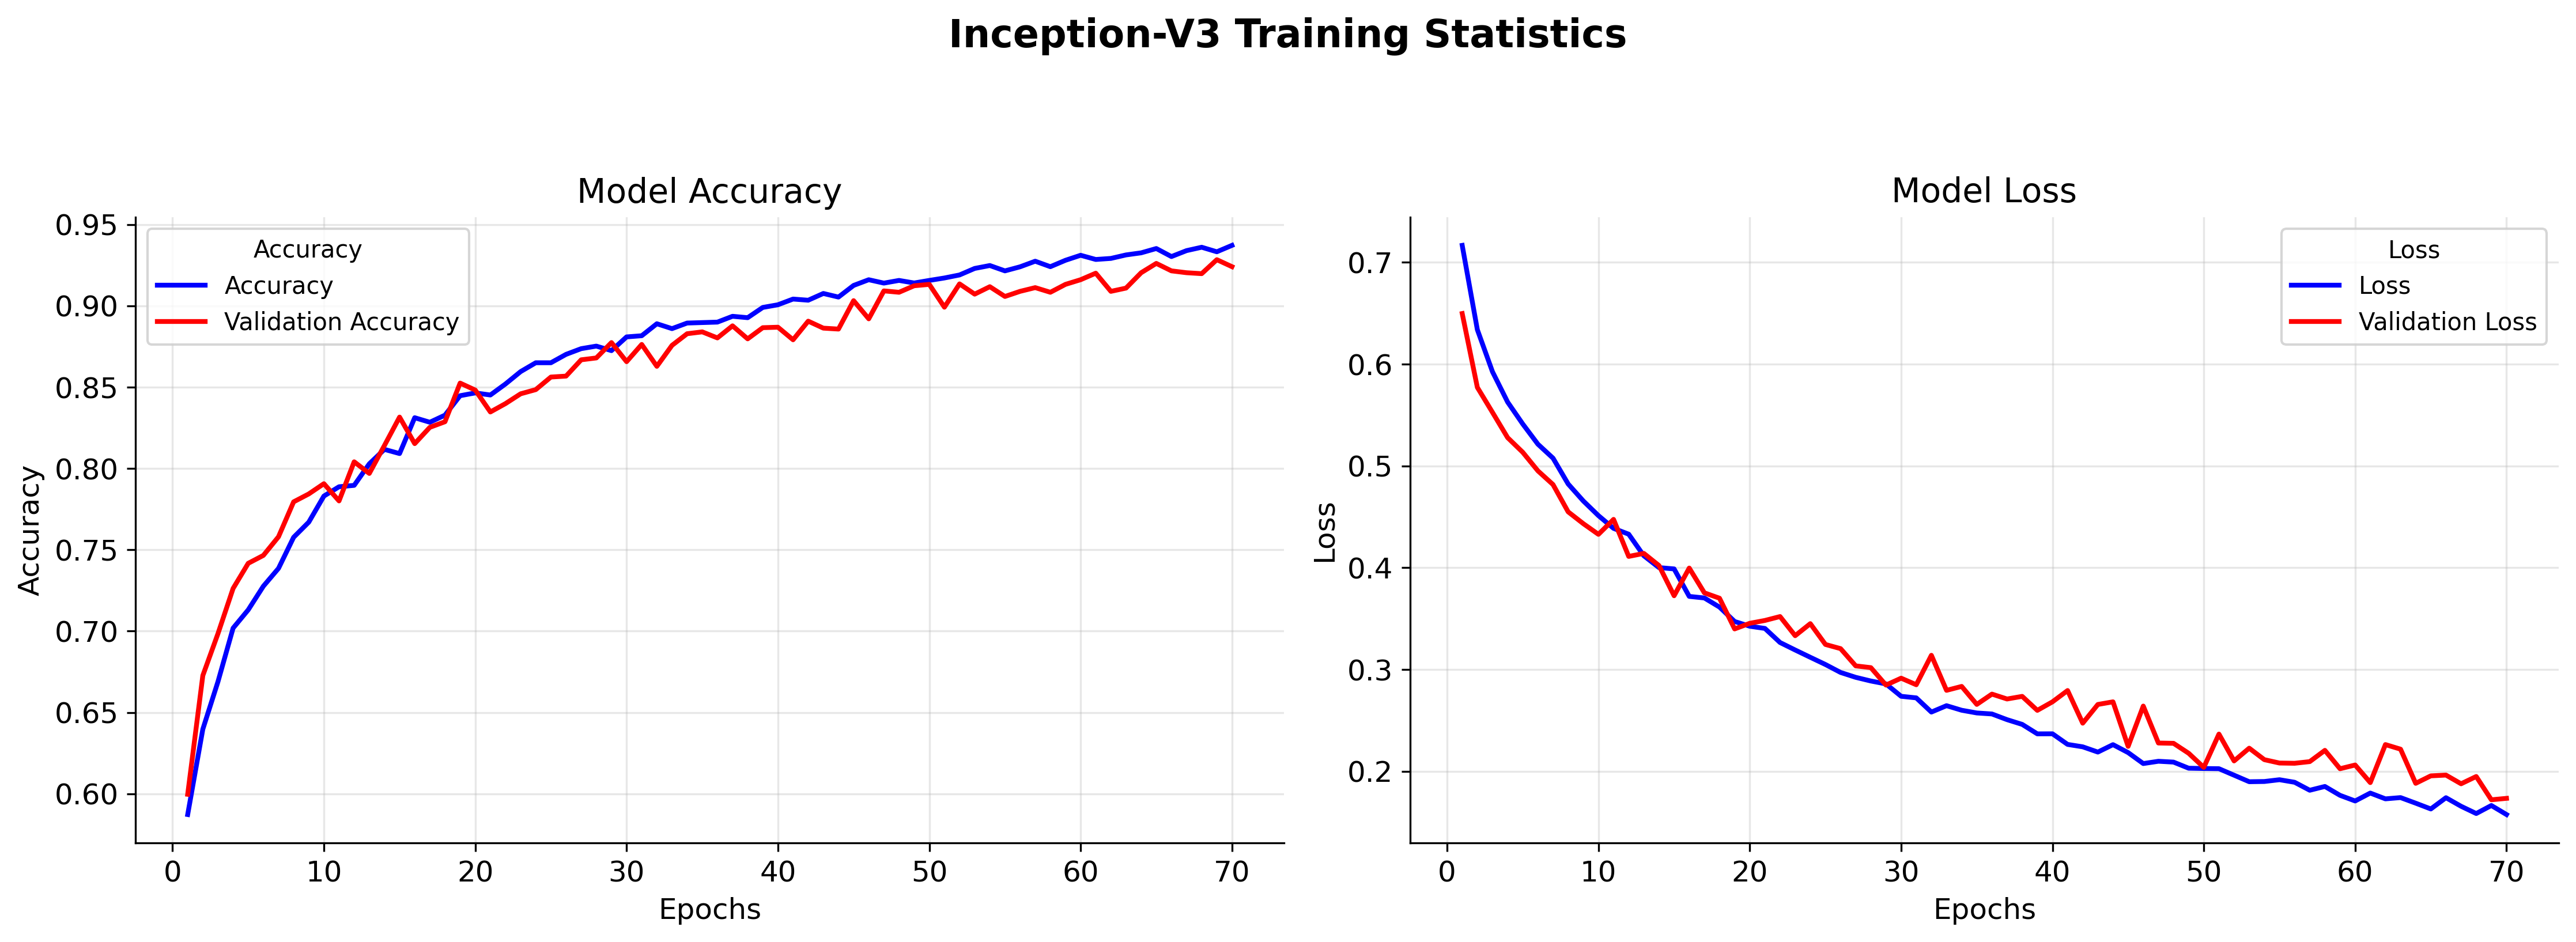

In [36]:
training_process_viz(pd.DataFrame(inception_model_train_history.history),
                     plot_title = 'Inception-V3 Training Statistics')

In [37]:
inceptionv3_report_df = generate_report(inception_cnn_model, test_dataset = test_dataset, row_indexes = ['InceptionV3'])
inceptionv3_report_df

234/234 ━━━━━━━━━━━━━━━━━━━━ 50s 213ms/step - accuracy: 0.9233 - loss: 0.1818
234/234 ━━━━━━━━━━━━━━━━━━━━ 52s 196ms/step


,MAE,MSE,RMSE,Loss,Accuracy,F1-Score
InceptionV3,0.495456,0.495456,0.703886,0.182163,0.925822,0.504544


#### **8.3.5 Save Modle**

In [38]:

# List all files in the checkpoint directory and sort them by modification time
list_of_files = glob.glob(os.path.join(INCEPTIONV3_CHECKPOINT_DIR_PATH, "*.h5"))
latest_file = max(list_of_files, key=os.path.getctime)  # Get the latest file

# Download the latest file (best model weights)
files.download(latest_file)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>